In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dlib
import math

%matplotlib inline

### read image

240 428


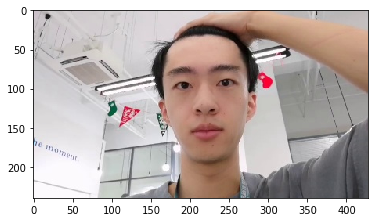

In [2]:
img_path = 'hq.jpg'
img = cv2.imread(img_path)[:,:,::-1]

HEIGHT, WIDTH, _ = img.shape
print(HEIGHT, WIDTH)
plt.imshow(img)
plt.show()

### face detect

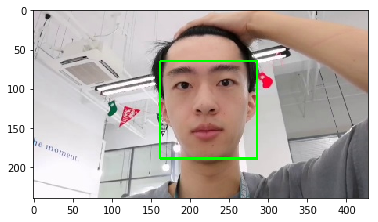

In [3]:
detector = dlib.get_frontal_face_detector()
rects = detector(img, 0)
face = rects[0]

top = face.top()
bottom = face.bottom()
left = face.left()
right = face.right()
img_detect = img.copy()
cv2.rectangle(img_detect, (left, top), (right, bottom), color=(0,255,0), thickness=2)
plt.imshow(img_detect)
plt.show()

### face landmarks

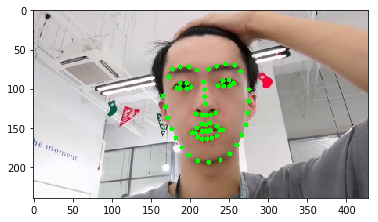

In [4]:
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
# Down from here: http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

shape = predictor(img, face)
img_landmarks = img.copy()
landmarks = []
for i in range(68):
    landmarks.append((shape.part(i).x, shape.part(i).y))
    cv2.circle(img_landmarks, landmarks[i], 3, (0,255,0), -1)
plt.imshow(img_landmarks)
plt.show()

### face mask

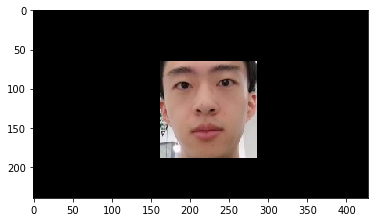

In [5]:
mask_dect = np.zeros(img.shape, np.uint8)
mask_dect[top:bottom, left:right, :] = 1

plt.imshow((img*mask_dect))
plt.show()

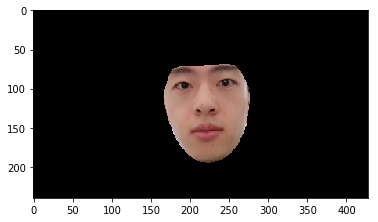

In [6]:
mask_landmarks = np.zeros(img.shape, np.uint8)
hull = cv2.convexHull(np.array(landmarks).reshape((-1,2)).astype(int)).flatten().reshape((-1,2))
cv2.fillConvexPoly(mask_landmarks, hull, (1,1,1))

plt.imshow((img*mask_landmarks))
plt.show()

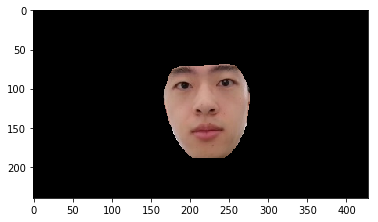

In [7]:
mask_both = mask_landmarks * mask_dect
plt.imshow(img * mask_both)
plt.show()

### face alignment

In [8]:
def cal_angle(leftEyeCenter, rightEyeCenter):
    dY = leftEyeCenter[1] - rightEyeCenter[1]
    dX = leftEyeCenter[0] - rightEyeCenter[0]
    return np.degrees(np.arctan2(dY, dX))

def rotation(img, angle):
    rows, cols = img.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
    return cv2.warpAffine(img, M, (cols, rows))

-3.6913859864512757


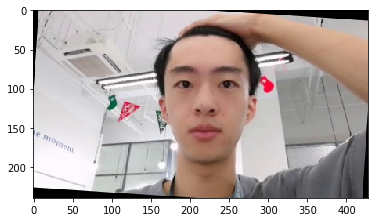

In [9]:
leftEye = landmarks[44]
rightEye = landmarks[37]

angle = cal_angle(leftEye, rightEye)
print(angle)
img_rot = rotation(img, angle)

plt.imshow(img_rot)
plt.show()

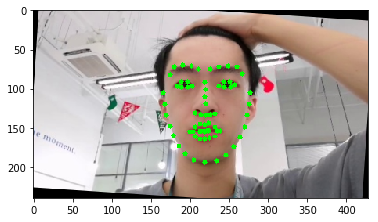

In [10]:
landmarks_align = []
rangle = np.deg2rad(angle)
cos = np.cos(rangle)
sin = np.sin(rangle)

for i in range(68):
    x_align = landmarks[i][0] - img.shape[1]/2
    y_align = landmarks[i][1] - img.shape[0]/2
    landmarks_align.append((int(x_align*cos + y_align*sin + img.shape[1]/2), int(x_align*(-sin)+y_align*cos + img.shape[0]/2)))

img_rot_landmarks = img_rot.copy()
for i in range(68):
    cv2.circle(img_rot_landmarks, landmarks_align[i], 3, (0,255,0), -1)
plt.imshow(img_rot_landmarks)
plt.show()

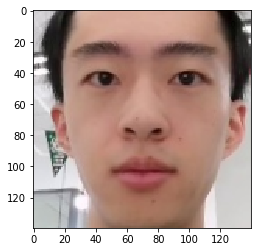

In [11]:
eyes_distance = landmarks_align[44][0] - landmarks_align[37][0]
width_crop = eyes_distance / 0.44
left_top_x = int(landmarks_align[37][0] - width_crop * 0.28)
left_top_y = int(landmarks_align[37][1] - width_crop * 0.28)
right_bottom_x = int(left_top_x + width_crop)
right_bottom_y = int(left_top_y + width_crop)
img_crop = img_rot[left_top_y:right_bottom_y, left_top_x:right_bottom_x, :]

plt.imshow(img_crop)
plt.show()

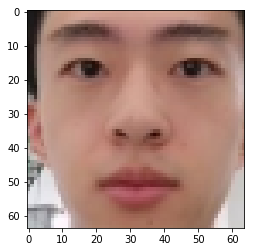

In [12]:
img_crop2 = cv2.resize(img_crop, (80,80))[8:72,8:72,:]
plt.imshow(img_crop2)
plt.show()